<a href="https://colab.research.google.com/github/adildhkh/deep-learning/blob/main/class_activation_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from scipy.ndimage import zoom
from PIL import Image

# Load the image from a local path
image_path = "/content/image-2.jpg"  # Local path to the image
img = Image.open(image_path)

# No need to use BytesIO or response.content here


In [5]:
# Load ResNet50 model pre-trained on ImageNet
model = resnet50.ResNet50(weights='imagenet')
model.summary()  # Print the model summary to identify final layers

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [6]:
# Identify the final activation layer and its output
final_activation_layer = 'conv5_block3_out'
final_dense_layer = model.get_layer('predictions')

In [7]:
# Create a sub-model for feature extraction
feature_extractor = tf.keras.Model(inputs=model.input,
                                   outputs=model.get_layer(final_activation_layer).output)


In [8]:
# Load and preprocess the image
img_resized = img.resize((224, 224))
img_array = image.img_to_array(img_resized)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [9]:
# Get feature maps and class probabilities
feature_maps = feature_extractor.predict(img_preprocessed)
predictions = model.predict(img_preprocessed)
decoded_predictions = decode_predictions(predictions, top=1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Extract the predicted class
predicted_class = decoded_predictions[0][1]  # Class label
predicted_class_index = np.argmax(predictions[0])  # Class index
predicted_class_score = decoded_predictions[0][2]

In [11]:
# Get the weights for the predicted class
class_weights = final_dense_layer.get_weights()[0]  # Shape: (2048, 1000)
class_specific_weights = class_weights[:, predicted_class_index]

In [12]:
# Generate the class activation map
cam = np.dot(feature_maps[0], class_specific_weights)

In [13]:
# Upsample the CAM to the input image size
cam_resized = zoom(cam, (32, 32), order=1)  # Upsample to 224x224
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())  # Normalize to [0, 1]


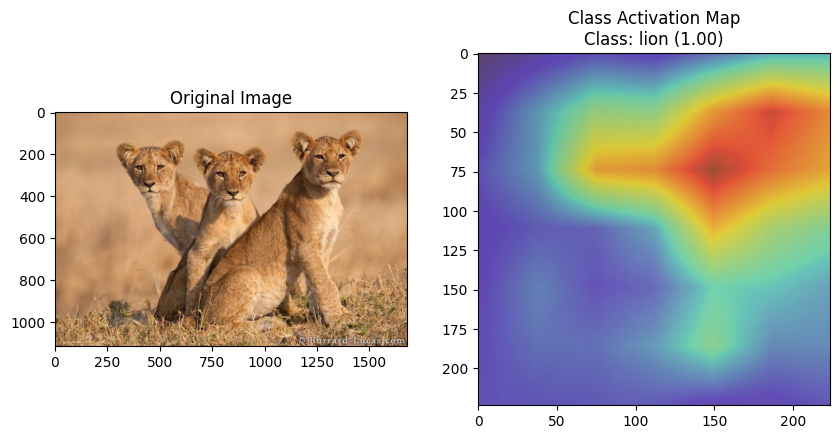

In [14]:
# Overlay the CAM on the original image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(cam_resized, cmap='jet', alpha=0.5)  # Overlay with transparency
plt.title(f"Class Activation Map\nClass: {predicted_class} ({predicted_class_score:.2f})")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


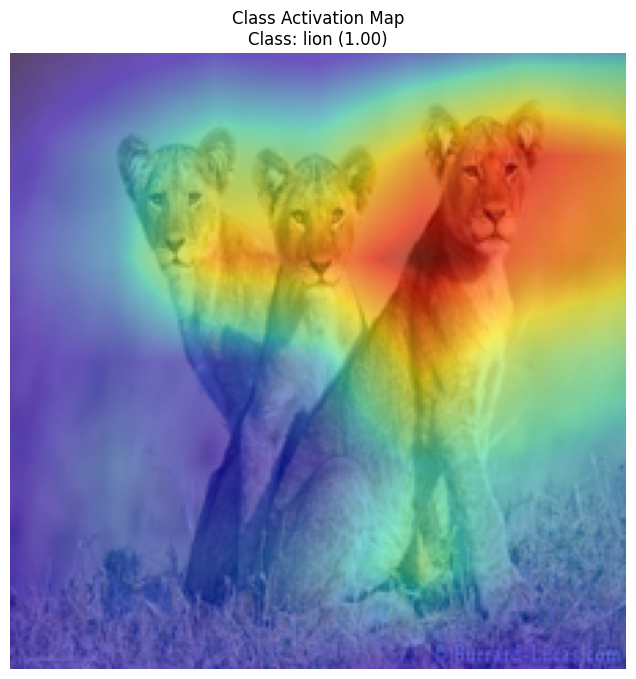

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from scipy.ndimage import zoom
from PIL import Image



# Load the image from a local path
image_path = "/content/image-2.jpg"  # Local path to the image
img = Image.open(image_path)


img_resized = img.resize((224, 224))  # Ensure the image is 224x224
img_array = image.img_to_array(img_resized)

# Load ResNet50 model pre-trained on ImageNet
model = resnet50.ResNet50(weights="imagenet")
feature_extractor = tf.keras.Model(
    inputs=model.input, outputs=model.get_layer("conv5_block3_out").output
)

# Preprocess the image
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

# Get feature maps and class probabilities
feature_maps = feature_extractor.predict(img_preprocessed)
predictions = model.predict(img_preprocessed)
decoded_predictions = decode_predictions(predictions, top=1)[0]

# Extract the predicted class
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = decoded_predictions[0][1]  # Class name
predicted_class_score = decoded_predictions[0][2]

# Get the weights for the predicted class
final_dense_layer = model.get_layer("predictions")
class_weights = final_dense_layer.get_weights()[0]  # Shape: (2048, 1000)
class_specific_weights = class_weights[:, predicted_class_index]

# Generate the class activation map
cam = np.dot(feature_maps[0], class_specific_weights)
cam_resized = zoom(cam, (224 / cam.shape[0], 224 / cam.shape[1]), order=1)  # Upsample
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())  # Normalize

# Plot the original image with the CAM overlayed
plt.figure(figsize=(8, 8))
plt.imshow(img_resized)
plt.imshow(cam_resized, cmap="jet", alpha=0.5)  # Overlay CAM with transparency
plt.title(f"Class Activation Map\nClass: {predicted_class_label} ({predicted_class_score:.2f})")
plt.axis("off")
plt.show()
